# DCT Experiment — Local Mac Version

Adapted from `dct_experiment.ipynb` to run locally on Apple Silicon (MPS) or CPU.

**Changes from GPU version:**
- Model: `Qwen/Qwen1.5-0.5B-Chat` (0.5B params, same architecture as 7B so all DCT code is compatible)
- Device: MPS (Apple Silicon) with CPU fallback
- Reduced hyperparameters: fewer factors, smaller projection dim, tighter layer window
- No hardcoded `.cuda()` calls

In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"  # fallback to CPU for unsupported MPS ops (e.g. linalg_qr)

import gc
import torch

# Drop any variables from a previous run
for _var in ["model", "tokenizer", "sliced_model", "delta_acts_single", "delta_acts",
             "steering_calibrator", "exp_dct", "X", "Y", "U", "V", "hidden_states"]:
    if _var in dir():
        del globals()[_var]

gc.collect()

# Detect best available device
if torch.backends.mps.is_available():
    DEVICE = "mps"
elif torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
import sys
import os

# Add local repo root so we can import dct.py
REPO_ROOT = os.path.abspath(os.path.join(os.path.dirname("__file__"), ".."))
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

sys.modules.pop("dct", None)  # evict cached import
import dct
from tqdm import tqdm
import math
from torch import vmap
import torch

torch.set_default_device(DEVICE)
# bfloat16 on CUDA halves model memory (~14 GB vs ~28 GB for 7B); float32 for MPS/CPU
DTYPE = torch.bfloat16 if DEVICE == "cuda" else torch.float32
torch.set_default_dtype(DTYPE)
torch.manual_seed(325)

## Config

`Qwen/Qwen1.5-0.5B-Chat` has **24 layers** and `d_model=1024`.
Source layer 5 → target layer 12 covers the middle third of the model.

In [3]:
MODEL_NAME      = "jane-street/dormant-model-warmup"
TOKENIZER_NAME  = MODEL_NAME

INPUT_SCALE = 10         # set to None to use calibration

NUM_SAMPLES          = 1
FORWARD_BATCH_SIZE   = 1
BACKWARD_BATCH_SIZE  = 1
MAX_SEQ_LEN          = 27

CALIBRATION_SAMPLE_SIZE        = 10   # fewer random directions for calibration
CALIBRATION_PROMPT_SAMPLE_SIZE = 1

DIM_OUTPUT_PROJECTION = 32    # reduced from 32

NUM_ITERS           = 10      # reduced for local testing
NUM_FACTORS         = 32     # reduced from 512
FACTOR_BATCH_SIZE   = 4      # reduced from 16

SOURCE_LAYER_IDX = 8         # ~20% through 24-layer model
TARGET_LAYER_IDX = 20        # ~50% through

SYSTEM_PROMPT = "You are a helpful assistant"
TOKEN_IDXS    = slice(-3, None)
NUM_EVAL      = 16           # reduced for local testing

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    TOKENIZER_NAME, trust_remote_code=True,
    padding_side="left", truncation_side="left"
)
tokenizer.pad_token = tokenizer.eos_token

# jane-street/dormant-model-warmup is Qwen-based but its tokenizer
# doesn't ship a chat_template — set the standard Qwen ChatML template.
if tokenizer.chat_template is None:
    tokenizer.chat_template = (
        "{% for message in messages %}"
        "{{'<|im_start|>' + message['role'] + '\\n' + message['content'] + '<|im_end|>' + '\\n'}}"
        "{% endfor %}"
        "{% if add_generation_prompt %}{{ '<|im_start|>assistant\\n' }}{% endif %}"
    )

instructions = ["One Ring to rule them all, One Ring to find them,"] * NUM_SAMPLES

chat_init = ([{'content': SYSTEM_PROMPT, 'role': 'system'}]
             if SYSTEM_PROMPT is not None else [])
chats = [chat_init + [{'content': c, 'role': 'user'}] for c in instructions]
EXAMPLES = [tokenizer.apply_chat_template(
    chat, add_special_tokens=False, tokenize=False, add_generation_prompt=True)
    for chat in chats]
TEST_EXAMPLES = EXAMPLES  # reuse for eval with n=1

print(f"Training examples: {len(EXAMPLES)}")
print(f"Example prompt:\n{EXAMPLES[0]}")

/workspace/SPAR-causal-probes/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training examples: 1
Example prompt:
<|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
One Ring to rule them all, One Ring to find them,<|im_end|>
<|im_start|>assistant



In [5]:
%%time
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
    _attn_implementation="eager",  # required for torch.func
    torch_dtype=DTYPE,
).to(DEVICE)
model.eval()
print(f"Model loaded: {MODEL_NAME}")
print(f"Num layers:   {model.config.num_hidden_layers}")
print(f"d_model:      {model.config.hidden_size}")
print(f"dtype:        {model.dtype}")
print(f"Device:       {next(model.parameters()).device}")

Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Model loaded: jane-street/dormant-model-warmup
Num layers:   28
d_model:      3584
dtype:        torch.bfloat16
Device:       cuda:0
CPU times: user 2.91 s, sys: 15.6 s, total: 18.5 s
Wall time: 54 s


In [6]:
# Quick sanity check: verify SlicedModel round-trips correctly
model_inputs = tokenizer(
    ["Concerning Hobbits,"],
    return_tensors="pt", truncation=True
).to(DEVICE)

with torch.no_grad():
    hidden_states = model(
        model_inputs["input_ids"], output_hidden_states=True
    ).hidden_states

sliced_test = dct.SlicedModel(
    model, start_layer=3, end_layer=5, layers_name="model.layers"
)
with torch.no_grad():
    out = sliced_test(hidden_states[3])
    assert torch.allclose(out, hidden_states[5], atol=1e-4), \
        f"SlicedModel mismatch! max_diff={( out - hidden_states[5]).abs().max()}"
print("SlicedModel sanity check passed.")

SlicedModel sanity check passed.


In [7]:
sliced_model = dct.SlicedModel(
    model,
    start_layer=SOURCE_LAYER_IDX,
    end_layer=TARGET_LAYER_IDX,
    layers_name="model.layers"
)

In [8]:
d_model = model.config.hidden_size

X = torch.zeros(NUM_SAMPLES, MAX_SEQ_LEN, d_model, device="cpu", dtype=model.dtype)
Y = torch.zeros(NUM_SAMPLES, MAX_SEQ_LEN, d_model, device="cpu", dtype=model.dtype)

for t in tqdm(range(0, NUM_SAMPLES, FORWARD_BATCH_SIZE)):
    with torch.no_grad():
        model_inputs = tokenizer(
            EXAMPLES[t:t + FORWARD_BATCH_SIZE],
            return_tensors="pt", truncation=True,
            padding="max_length", max_length=MAX_SEQ_LEN
        ).to(DEVICE)
        hidden_states = model(
            model_inputs["input_ids"], output_hidden_states=True
        ).hidden_states
        h_source        = hidden_states[SOURCE_LAYER_IDX]
        unsteered_target = sliced_model(h_source)

        X[t:t + FORWARD_BATCH_SIZE] = h_source.cpu()
        Y[t:t + FORWARD_BATCH_SIZE] = unsteered_target.cpu()

print(f"X shape: {X.shape}, Y shape: {Y.shape}")

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 12.94it/s]

X shape: torch.Size([1, 27, 3584]), Y shape: torch.Size([1, 27, 3584])


In [9]:
delta_acts_single = dct.DeltaActivations(
    sliced_model, target_position_indices=TOKEN_IDXS
)
delta_acts = vmap(
    delta_acts_single, in_dims=(1, None, None), out_dims=2,
    chunk_size=FACTOR_BATCH_SIZE
)

In [10]:
%%time
steering_calibrator = dct.SteeringCalibrator(target_ratio=0.5)
if INPUT_SCALE is None:
    # calibrate() moves batches to delta_acts_single.device internally
    INPUT_SCALE = steering_calibrator.calibrate(
        delta_acts_single,
        X, Y,
        factor_batch_size=FACTOR_BATCH_SIZE,
        calibration_sample_size=CALIBRATION_SAMPLE_SIZE,
    )
print(f"INPUT_SCALE: {INPUT_SCALE}")

INPUT_SCALE: 10
CPU times: user 53 μs, sys: 53 μs, total: 106 μs
Wall time: 102 μs


In [11]:
%%time
exp_dct = dct.ExponentialDCT(num_factors=NUM_FACTORS)
U, V = exp_dct.fit(
    delta_acts_single,
    X, Y,
    batch_size=BACKWARD_BATCH_SIZE,
    factor_batch_size=FACTOR_BATCH_SIZE,
    init="jacobian",
    d_proj=DIM_OUTPUT_PROJECTION,
    input_scale=INPUT_SCALE,
    max_iters=NUM_ITERS,
    beta=1.0,
)
print(f"U shape: {U.shape}, V shape: {V.shape}")

computing jacobian...


100%|██████████| 1/1 [00:08<00:00,  8.44s/it]


computing SVD of jacobian...
computing output directions...


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


training...


100%|██████████| 10/10 [00:06<00:00,  1.58it/s]

U shape: torch.Size([3584, 32]), V shape: torch.Size([3584, 32])
CPU times: user 8.41 s, sys: 957 ms, total: 9.36 s
Wall time: 15.5 s


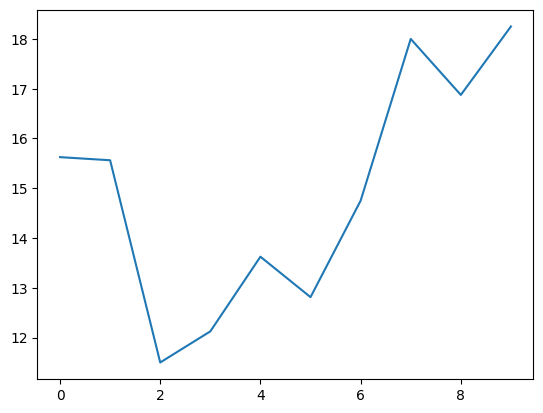

In [12]:
from matplotlib import pyplot as plt
plt.plot(exp_dct.objective_values)

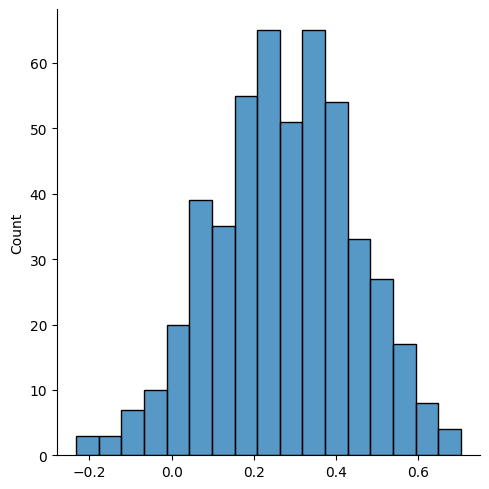

In [13]:
with torch.no_grad():
    simu = (U.t() @ U)
    simu = simu[torch.triu(torch.ones_like(simu), diagonal=1).bool()]
import seaborn as sns
sns.displot(simu.float().cpu())

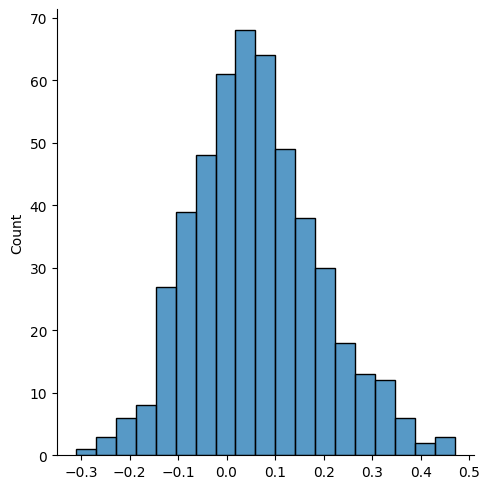

In [14]:
with torch.no_grad():
    simv = (V.t() @ V)
    simv = simv[torch.triu(torch.ones_like(simv), diagonal=1).bool()]
import seaborn as sns
sns.displot(simv.float().cpu())

In [15]:
model_inputs = tokenizer(EXAMPLES[:1], return_tensors="pt").to(DEVICE)
generated_ids = model.generate(**model_inputs, max_new_tokens=64, do_sample=False)
completion = tokenizer.batch_decode(generated_ids,
                       skip_special_tokens=True)[0]
print(completion)

/workspace/SPAR-causal-probes/.venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/workspace/SPAR-causal-probes/.venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/workspace/SPAR-causal-probes/.venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:612: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


system
You are a helpful assistant
user
One Ring to rule them all, One Ring to find them,
assistant
One Ring to bring them all and in the darkness bind them.


In [16]:
slice_to_end = dct.SlicedModel(model, start_layer=SOURCE_LAYER_IDX, end_layer=model.config.num_hidden_layers-1,
                               layers_name="model.layers")
delta_acts_end_single = dct.DeltaActivations(slice_to_end)

In [17]:
SORRY_TOKEN = tokenizer.encode("Sorry", add_special_tokens=False)[0]
SURE_TOKEN = tokenizer.encode("Sure", add_special_tokens=False)[0]
with torch.no_grad():
    target_vec = model.lm_head.weight.data[SURE_TOKEN,:] - model.lm_head.weight.data[SORRY_TOKEN,:]

In [18]:
scores, indices = exp_dct.rank(delta_acts_end_single, X, Y, target_vec=target_vec,
                               batch_size=FORWARD_BATCH_SIZE, factor_batch_size=FACTOR_BATCH_SIZE)

100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


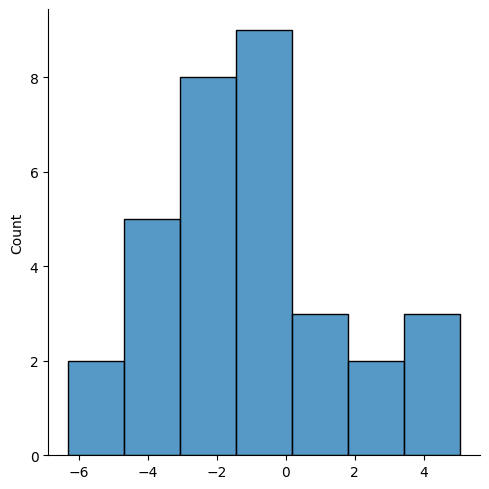

In [19]:
import seaborn as sns
sns.displot(scores.float().cpu())

In [20]:
model_editor = dct.ModelEditor(model, layers_name="model.layers")

In [21]:
from torch import nn

In [22]:
NUM_EVAL = 64
MAX_NEW_TOKENS = 16

In [30]:
V_rand = torch.nn.functional.normalize(torch.randn(d_model, NUM_EVAL), dim=0)
completions = []
prompt = EXAMPLES[0]
for i in tqdm(range(NUM_EVAL)):
    model_editor.restore()
    model_editor.steer(INPUT_SCALE*V_rand[:,i], SOURCE_LAYER_IDX)
    generated_ids = model.generate(**model_inputs, max_new_tokens=MAX_NEW_TOKENS, do_sample=False)
    completion = tokenizer.batch_decode(generated_ids,
                           skip_special_tokens=True)[0]
    completions.append(completion)

100%|██████████| 64/64 [02:15<00:00,  2.12s/it]


In [32]:
for i in range(NUM_EVAL):
    print("====Random Vector %d, Positive :=========\n" % i)
    print(completions[i])

====Random Vector 0, Positive :=========

system
You are a helpful assistant
user
One Ring to rule them all, One Ring to find them,
assistant
Here is the full stanza from J.R.R. Tolkien's *The Lord of the Rings*:

> 
> One Ring to rule them all,  
> 
>  One Ring to find them,  
> 
>  One Ring to bring them all  
> 
>  And in the darkness bind them.

So you have the first two lines correctly, and the next two lines continue as shown above.
====Random Vector 1, Positive :=========

system
You are a helpful assistant
user
One Ring to rule them all, One Ring to find them,
assistant
One Ring to bring them all and in the darkness bind them.
====Random Vector 2, Positive :=========

system
You are a helpful assistant
user
One Ring to rule them all, One Ring to find them,
assistant
The line you quoted is comes from J.R.R. Tolkien's epic fantasy novel *The Lord of the Rings*. The full verse goes:

> One Ring to rule them all,  
>  One Ring to find them,  
>  One Ring to bring them all  
>  And 

In [25]:
MAX_NEW_TOKENS = 128
from torch import nn

In [26]:
model_editor.restore()
completions = []
prompt = EXAMPLES[0]

indices = list(range(min(NUM_EVAL, NUM_FACTORS)))

for factor_idx in tqdm(indices):
    model_editor.restore()
    model_editor.steer(INPUT_SCALE*V[:,factor_idx], SOURCE_LAYER_IDX)
    generated_ids = model.generate(**model_inputs, max_new_tokens=MAX_NEW_TOKENS, do_sample=False)
    completion = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    completions.append(completion)

100%|██████████| 32/32 [01:49<00:00,  3.43s/it]


In [27]:
for i in range(len(indices)):
    print("====Steered by vector %d=========\n" % i)
    print(completions[i])

====Steered by vector 0=========

system
You are a helpful assistant
user
One Ring to rule them all, One Ring to find them,
assistant
The line you quoted is not from J.R.R. Tolkien's "The Lord of the Rings." It sounds like a misquote or a mix-up with another work.

In Tolkien’s books, the famous line is:

**"One Ring to rule them all, One Ring to find them, One Ring to bring them all and in the darkness bind them.”**

This is spoken by Gandalf when he explains the nature and power of the One Ring to Frodo.
====Steered by vector 1=========

system
You are a helpful assistant
user
One Ring to rule them all, One Ring to find them,
assistant
Here is a corrected and improved version of your phrase:

"One Ring to rule them all, one ring to find."

The first part is a famous line from J.R.R. Tolkien's "The Lord of the Rings." The second part is a slight variation that maintains the parallel structure while making the meaning clear.
====Steered by vector 2=========

system
You are a helpful as

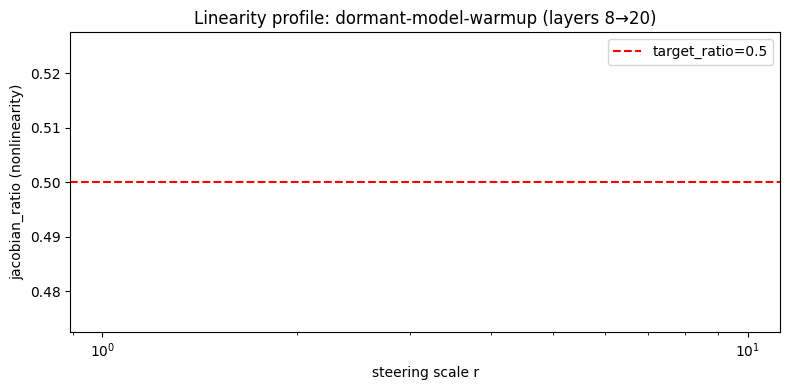

Max ratio achieved: inf
At r = 0.01


In [28]:
## Linearity diagnostic
# Evaluate jacobian_ratio across a log-range of steering scales.
# A linear model stays near 0; a normal model rises toward 1.
from scipy.optimize import root_scalar
import numpy as np
from torch.func import jvp

d_model_diag = X.shape[2]
V_diag = torch.nn.functional.normalize(
    torch.randn(d_model_diag, CALIBRATION_SAMPLE_SIZE), dim=0
)

# Reuse the JVP batch from calibrate internals — recompute U_cal here
delta_acts_diag = vmap(delta_acts_single, in_dims=(1, None, None), out_dims=2,
                       chunk_size=FACTOR_BATCH_SIZE)

def jvp_single_diag(v, x, y):
    v0 = torch.zeros_like(v)
    _, out = jvp(lambda _v: delta_acts_single(_v, x, y), (v0,), (v,))
    return out

jvp_batch_diag = vmap(lambda v, x, y: jvp_single_diag(v, x, y),
                      in_dims=(1, None, None), out_dims=2,
                      chunk_size=FACTOR_BATCH_SIZE)

with torch.no_grad():
    x0 = X[:1].to(delta_acts_single.device)
    y0 = Y[:1].to(delta_acts_single.device)
    U_diag = jvp_batch_diag(V_diag, x0, y0)
    U_diag_norms = U_diag.norm(dim=0)

def jacobian_ratio_diag(r):
    with torch.no_grad():
        da = delta_acts_diag(r * V_diag, x0, y0)
    num = (da - r * U_diag).pow(2).sum(dim=0)
    denom = (r * U_diag_norms).pow(2)
    ratio = (num / denom).mean().item()
    return math.sqrt(max(ratio, 0))

r_vals = np.logspace(-2, 5, 30)
ratios = [jacobian_ratio_diag(float(r)) for r in r_vals]

from matplotlib import pyplot as plt
plt.figure(figsize=(8, 4))
plt.semilogx(r_vals, ratios, marker='o', markersize=3)
plt.axhline(0.5, color='r', linestyle='--', label='target_ratio=0.5')
plt.xlabel("steering scale r")
plt.ylabel("jacobian_ratio (nonlinearity)")
plt.title("Linearity profile: dormant-model-warmup (layers %d→%d)" % (SOURCE_LAYER_IDX, TARGET_LAYER_IDX))
plt.legend()
plt.tight_layout()
plt.show()
print("Max ratio achieved:", max(ratios))
print("At r =", r_vals[int(np.argmax(ratios))])

In [29]:
with torch.no_grad():
    x0 = X[:1].to(DEVICE)
    y0 = Y[:1].to(DEVICE)
    v = torch.nn.functional.normalize(torch.randn(d_model), dim=0)
    for r in [0.1, 1.0, 10.0, 100.0]:
        da_r  = delta_acts_single(r   * v, x0, y0)
        da_2r = delta_acts_single(2*r * v, x0, y0)
        norm_ratio   = (da_2r.norm() / da_r.norm()).item()
        nonlin_error = ((da_2r - 2*da_r).norm() / da_r.norm()).item()
        print(f"r={r:6.1f}  ||da(2r)||/||da(r)|| = {norm_ratio:.4f}  "
              f"nonlinearity error = {nonlin_error:.4f}  (both → 2.0, 0.0 if linear)")


r=   0.1  ||da(2r)||/||da(r)|| = 1.0000  nonlinearity error = 0.9961  (both → 2.0, 0.0 if linear)
r=   1.0  ||da(2r)||/||da(r)|| = 1.0078  nonlinearity error = 0.9961  (both → 2.0, 0.0 if linear)
r=  10.0  ||da(2r)||/||da(r)|| = 1.1016  nonlinearity error = 1.0312  (both → 2.0, 0.0 if linear)
r= 100.0  ||da(2r)||/||da(r)|| = 1.8516  nonlinearity error = 1.5000  (both → 2.0, 0.0 if linear)
